In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from dfreproject import calculate_rays
from sunpy.data.sample import AIA_193_JUN2012, STEREO_A_195_JUN2012
import matplotlib.pyplot as plt
import torch
from astropy.io.fits import PrimaryHDU
from dfreproject import TensorHDU
from einops import rearrange, reduce, repeat

torch.Size([1, 1024, 1024, 3])
rays requires_grad: True


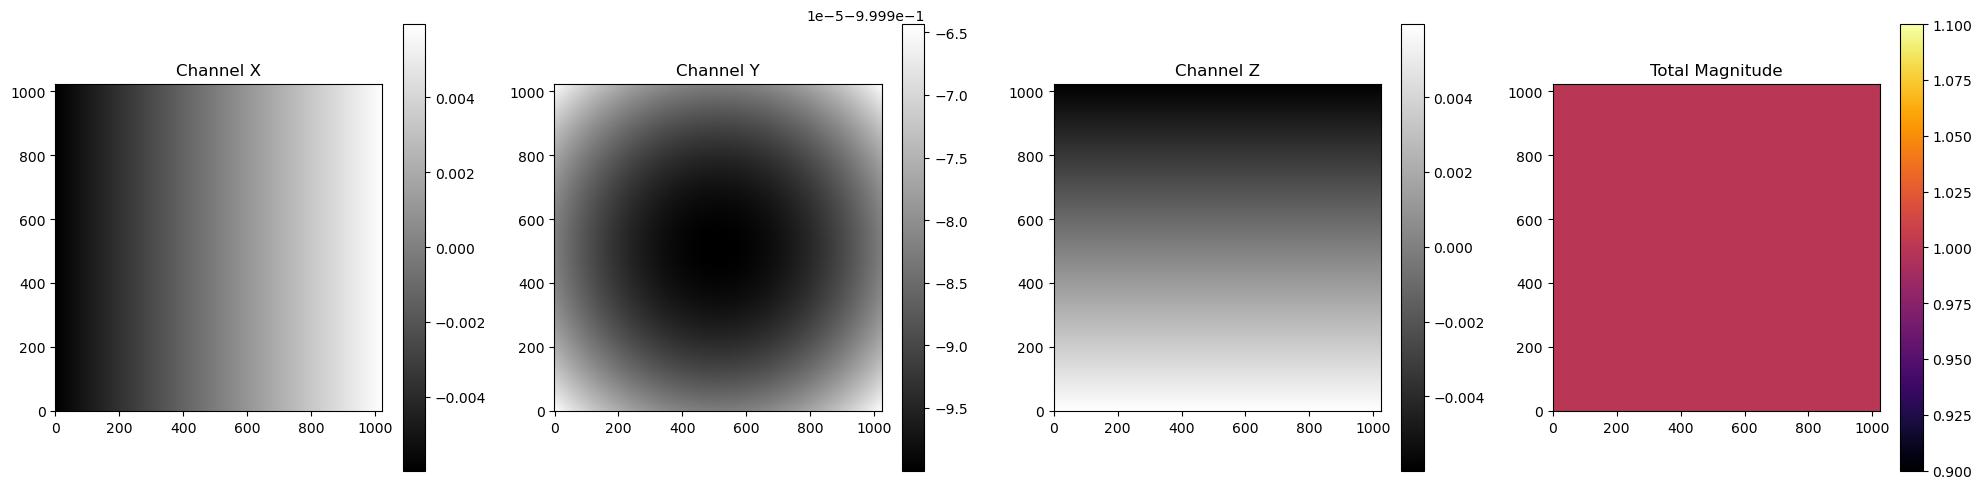

[[ 0.00594749  0.00594748  0.00594747 ...  0.00593576  0.00593575
   0.00593574]
 [ 0.00593584  0.00593583  0.00593582 ...  0.00592411  0.0059241
   0.00592409]
 [ 0.00592419  0.00592418  0.00592417 ...  0.00591246  0.00591245
   0.00591244]
 ...
 [-0.00594696 -0.00594698 -0.00594699 ... -0.0059587  -0.00595871
  -0.00595872]
 [-0.00595861 -0.00595863 -0.00595864 ... -0.00597035 -0.00597036
  -0.00597037]
 [-0.00597026 -0.00597027 -0.00597029 ... -0.005982   -0.00598201
  -0.00598202]]
obs: tensor([0.0000e+00, 1.5169e+11, 9.2886e-06], device='cuda:0',
       dtype=torch.float64)
Magnitude of obs: 151693704651.16


In [ ]:
# Load source and target images
source_hdu = fits.open(AIA_193_JUN2012)[1]
source_hdu = PrimaryHDU(source_hdu.data, header=source_hdu.header)

shape = source_hdu.data.shape


source_hdu = TensorHDU(torch.tensor(source_hdu.data, requires_grad=True), source_hdu.header)
source_wcs = WCS(source_hdu.header)

# Use the downscale_and_update_fits function defined above
# downscale_size = 1024
# source_hdu, target_hdu, target_wcs = downscale_and_update_fits(source_hdu, target_hdu, target_wcs, downscale_size=downscale_size)
# print(type(source_hdu))

# Extract HGLT_OBS (heliographic latitude of observer) from WCS if present
# print("Lat", source_wcs.wcs.aux.hglt_obs)
# print("Lon", source_wcs.wcs.aux.hgln_obs)
# print("HGLT_OBS from WCS:", hglt_obs)

source_wcs.wcs.aux.hglt_obs = 90.0  # Set to zero for this example
source_wcs.wcs.aux.hgln_obs = 0.0  # Set to


obs, rays = calculate_rays(
    source_wcs = source_wcs,
    shape_out=shape,
    requires_grad=False,
)

print(rays.shape)  # Should match target_hdu.data.shape
print("rays requires_grad:", rays.requires_grad)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

channels = ['X', 'Y', 'Z']
for i in range(3):
    ax = axes[i]
    im = ax.imshow(rays[0, :, :, i].cpu().detach().numpy(), origin='lower', cmap='gray')
    ax.set_title(f'Channel {channels[i]}')
    plt.colorbar(im, ax=ax)

# Total magnitude
magnitude = torch.norm(rays[0], dim=-1).cpu().detach().numpy()
im = axes[3].imshow(magnitude, origin='lower', cmap='inferno')
axes[3].set_title('Total Magnitude')
plt.colorbar(im, ax=axes[3])

plt.tight_layout()
plt.show()

z = rays[0, :, :, 2].cpu().detach().numpy()
print(z)

print("obs:", obs)
print("Magnitude of obs:", torch.norm(obs).item())


rsun = int(6.9634e8)

def sun_sphere_scalar(coords, radius=rsun, radius2= rsun/2, radius3 = rsun/3, value=1.0):
    """
    Returns an array where points inside the sphere of given radius are set to `value`, else 0.
    coords: tensor or array of shape (..., 3) representing (x, y, z) coordinates (units: meters)
    radius: radius of the sphere (default: Sun's radius in meters)
    value: value to assign inside the sphere
    """
    if isinstance(coords, torch.Tensor):
        dist2 = coords[..., 0]**2 + coords[..., 1]**2 + coords[..., 2]**2
        mask = dist2 <= radius**2
        # Define new sphere center: shift x and y positively, keep z the same
        # Example: center at (radius, radius, 0)
        center_2 = torch.tensor([radius, radius, 0.0], dtype=coords.dtype, device=coords.device)
        dist2_new = (coords[..., 0] - center_2[0])**2 + (coords[..., 1] - center_2[1])**2 + (coords[..., 2] - center_2[2])**2
        mask_new = dist2_new <= radius2**2
        # Intersecting region: both masks True
        mask_combined = mask | mask_new

        center_3 = torch.tensor([-radius, -radius, radius/2], dtype=coords.dtype, device=coords.device)
        dist2_new = (coords[..., 0] - center_3[0])**2 + (coords[..., 1] - center_3[1])**2 + (coords[..., 2] - center_3[2])**2
        mask_new = dist2_new <= radius3**2

        # Torus parameters
        torus_center = center_3
        torus_major_radius = radius3 * 1.5  # distance from center to tube center
        torus_minor_radius = radius3 / 4    # tube radius

        # Compute torus mask: (sqrt(x^2 + y^2) - major_radius)^2 + z^2 <= minor_radius^2
        x = coords[..., 0] - torus_center[0]
        y = coords[..., 1] - torus_center[1]
        z = coords[..., 2] - torus_center[2]
        torus_r = torch.sqrt(x**2 + z**2)
        torus_mask = ((torus_r - torus_major_radius)**2 + y**2) <= torus_minor_radius**2

        mask_combined = mask_combined | mask_new | torus_mask


    
        result = torch.where(mask_combined, torch.tensor(value, dtype=coords.dtype, device=coords.device), torch.tensor(0.0, dtype=coords.dtype, device=coords.device))
        return result


    

rays_no_batch requires_grad: True
torch.Size([697])
Progress:  99%output_tensor requires_grad: True


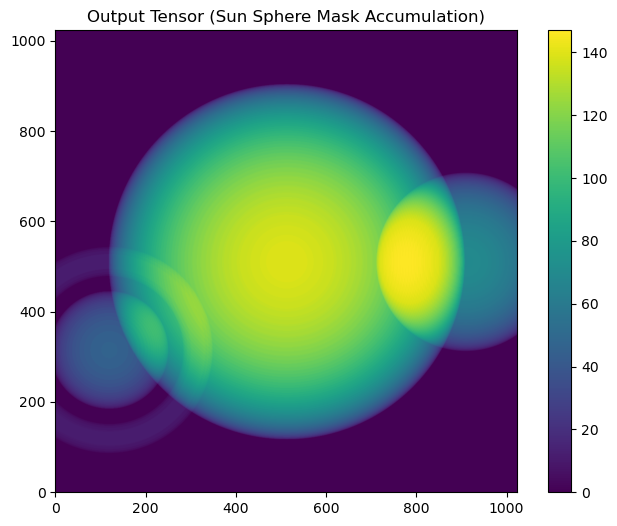

Memory allocated on CUDA: 269.63 MB
Max memory allocated on CUDA: 423.77 MB


In [3]:

dsun = torch.norm(obs)  # Distance from observer to Sun in meters

dsun = dsun.to(dtype=torch.int64, device=obs.device)

# Add the obs vector to each coordinate in rays[0]
# rays has shape (1, H, W, 3), obs has shape (3,)
# Remove batch dimension for easier broadcasting and visualization
rays_no_batch = rays[0]  # shape (H, W, 3)
print("rays_no_batch requires_grad:", rays_no_batch.requires_grad)
dx = 10000000

rays_with_obs = rays_no_batch*(dsun - 5*rsun - dx) + obs


output_tensor = torch.zeros_like(rays_with_obs[..., 0], requires_grad=True)  # Initialize output tensor with same shape as rays_with_obs

steps = torch.arange(dsun - 5*rsun, dsun + 5*rsun, dx, device=dsun.device, dtype=dsun.dtype)
print(steps.size())


for i in range(dsun - 5*rsun, dsun + 5*rsun, dx):
    print(f"\rProgress:  {(100*(i - (dsun- 5*rsun)))//(10*rsun)}%", end="")
    rays_with_obs = rays_with_obs + rays_no_batch * dx
    # sun_sphere_scalar returns shape (H, W), matching output_tensor
    output_tensor = output_tensor + sun_sphere_scalar(rays_with_obs, radius=6.9634e8, value=1.0)



print("output_tensor requires_grad:", output_tensor.requires_grad)
output_tensor.sum().backward()
plt.figure(figsize=(8, 6))
plt.imshow(output_tensor.cpu().detach().numpy(), origin='lower', cmap='viridis')
plt.title('Output Tensor (Sun Sphere Mask Accumulation)')
plt.colorbar()
plt.show()


del rays_with_obs, rays_no_batch, output_tensor
torch.cuda.empty_cache()
print(f"Memory allocated on CUDA: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
print(f"Max memory allocated on CUDA: {torch.cuda.max_memory_allocated() / 1e6:.2f} MB")


# steps = torch.arange(dsun - 5*rsun, dsun + 5*rsun, dx, device=dsun.device, dtype=rays.dtype)
# # rays_with_obs shape: (H, W, 3)
# # steps shape: (1, 1, 1, S)
# # rays_no_batch shape: (H, W, 3)
# # obs shape: (3,)

# # Expand rays_no_batch and obs for broadcasting
# rays_no_batch_exp = rays_no_batch.unsqueeze(-1)  # (H, W, 3, 1)
# obs_exp = obs.view(1, 1, 3, 1)  # (1, 1, 3, 1)

# # Compute rays for all steps in one go
# rays_with_all_steps = rays_no_batch_exp * steps + obs_exp  # (H, W, 3, S)

# # Move last axis to last position for sun_sphere_scalar
# rays_with_all_steps = rays_with_all_steps.permute(0, 1, 3, 2)  # (H, W, S, 3)

# # Apply sun_sphere_scalar to all positions and steps
# mask = sun_sphere_scalar(rays_with_all_steps, radius=6.9634e8, value=1.0)  # (H, W, S)

# # Sum over steps axis to accumulate
# output_tensor = mask.sum(dim=-1)  # (H, W)